# From file config.json

In [2]:
import os 
import cv2 
from PIL import Image
import json 
import numpy as np

import hydra 
from omegaconf import DictConfig, OmegaConf

with hydra.initialize(version_base='1.2', config_path='config'):
    cfg = hydra.compose(config_name='default_data')
    print(OmegaConf.to_yaml(cfg))

from matplotlib import pyplot as plt 
def plot_bar(stat, title:str='template'):
    name = list(stat.keys())
    price = list(stat.values())
    # Figure Size
    fig, ax = plt.subplots(figsize =(16, 9))
    
    # Horizontal Bar Plot
    ax.barh(name, price)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    
    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
    
    # Show top values
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                str(round((i.get_width()), 2)),
                fontsize = 10, fontweight ='bold',
                color ='grey')
    
    # Add Plot Title
    ax.set_title(title,
                loc ='left', )
    
    # Add Text watermark
    fig.text(0.9, 0.15, 'phidch', fontsize = 12,
            color ='grey', ha ='right', va ='bottom',
            alpha = 0.7)
    
    # Show Plot
    plt.show()

stat = {}
with open(f'{cfg.eval_folder[0]}/objectclasses.json', 'r') as f:
    meta_data = json.load(f)
    for meta in meta_data:
        stat[meta['Name']] = 0

eval_folder:
- /home/robotic/Downloads/phidch_ws/src/bmw-lab/scripts/sordi-2022/data/eval



/home/robotic/miniconda3/envs/py37/lib/python3.7/site-packages/hydra/_internal/config_loader_impl.py:216: UserWarning: provider=hydra.searchpath in main, path=config is not available.
  message=f"provider={source.provider}, path={source.path} is not available.",


### stat of num bbox for class

/home/robotic/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


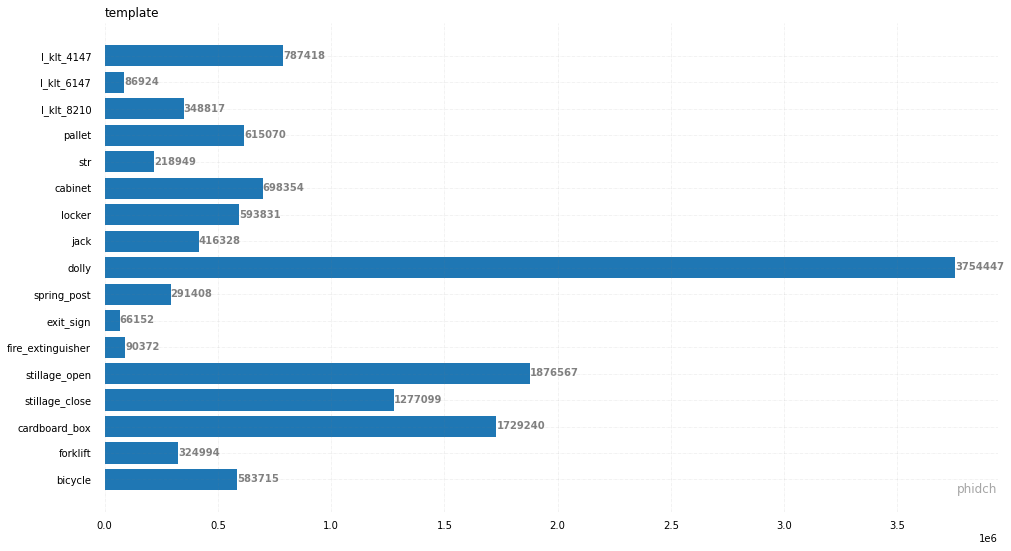

In [6]:
with open(f'data/SORDI/config.json', 'r') as f:
    datasets = json.load(f)

stat_no_check_with_single_assets = stat.copy()
for dataset in datasets:
    objs = dataset['object_classes']
    for obj in objs.keys():
        stat_no_check_with_single_assets[obj] += objs[obj]

plot_bar(stat_no_check_with_single_assets)

### use db mysql

In [7]:
import sqlite3
from sqlite3 import Error

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

In [8]:
stat

{'l_klt_4147': 0,
 'l_klt_6147': 0,
 'l_klt_8210': 0,
 'pallet': 0,
 'str': 0,
 'cabinet': 0,
 'locker': 0,
 'jack': 0,
 'dolly': 0,
 'spring_post': 0,
 'exit_sign': 0,
 'fire_extinguisher': 0,
 'stillage_open': 0,
 'stillage_close': 0,
 'cardboard_box': 0,
 'forklift': 0,
 'bicycle': 0}

### stat of image resolution

/home/robotic/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


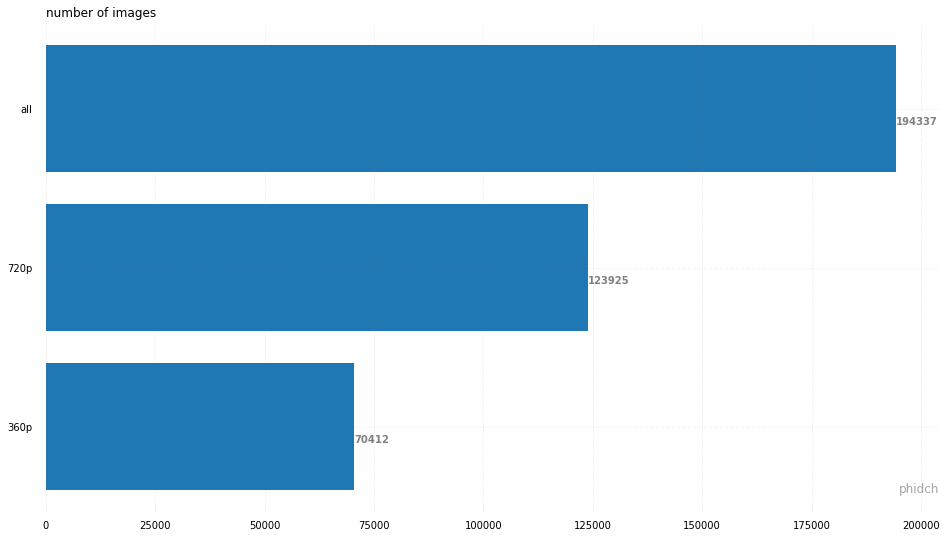

In [9]:
def stat_num_img(db_file='../SORDI-Data-Pipeline-Reader/SORDI.sqlite'):
    stat = {}
    conn = create_connection(db_file)
    cur = conn.cursor()

    sql = '''SELECT COUNT(*) FROM FRAME'''
    rows = [r for r in cur.execute(sql)]
    stat['all'] = rows[0][0]
    

    sql = '''SELECT COUNT(*) FROM FRAME WHERE width=1280'''
    rows = [r for r in cur.execute(sql)]
    stat['720p'] = rows[0][0]

    sql = '''SELECT COUNT(*) FROM FRAME WHERE width=640'''
    rows = [r for r in cur.execute(sql)]
    stat['360p'] = rows[0][0]

    plot_bar(stat, 'number of images')

stat_num_img()

### stat num image for class

/home/robotic/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


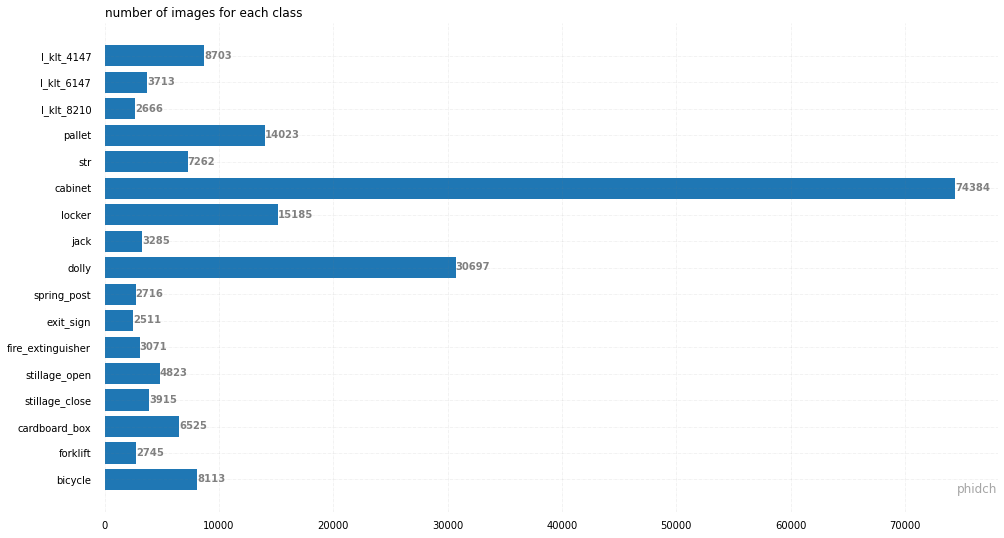

In [30]:
def stat_num_img_for_class(db_file='../SORDI-Data-Pipeline-Reader/SORDI.sqlite'):
    global stat
    curr = stat.copy()

    conn = create_connection(db_file)
    cur = conn.cursor()

    for cls in curr.keys():
        sql = f'''select count(*) from FRAME where json_extract(labels, '$[0].ObjectClassName')='{cls}' '''
        rows = [r for r in cur.execute(sql)]
        curr[cls] = rows[0][0]

    plot_bar(curr, 'number of images for each class')

stat_num_img_for_class()

### visualize image

In [144]:
from pycocotools.coco import COCO

coco = COCO("data/SORDI/annotations/sordi-non-single-asserts-train500.json")
ids = coco.getImgIds()
id = ids[1]

img = coco.loadImgs(id)
img_path = 'data' + img[0]['file_name']
annot = coco.loadAnns(coco.getAnnIds(id))
print(annot)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
[{'iscrowd': 0, 'image_id': 2, 'category_id': 1110, 'id': 8, 'bbox': [214, 73, 58, 4], 'area': 232}, {'iscrowd': 0, 'image_id': 2, 'category_id': 1100, 'id': 9, 'bbox': [218, 65, 83, 12], 'area': 996}, {'iscrowd': 0, 'image_id': 2, 'category_id': 1110, 'id': 10, 'bbox': [272, 75, 5, 0], 'area': 0}, {'iscrowd': 0, 'image_id': 2, 'category_id': 1100, 'id': 11, 'bbox': [277, 66, 134, 11], 'area': 1474}, {'iscrowd': 0, 'image_id': 2, 'category_id': 1110, 'id': 12, 'bbox': [414, 76, 94, 60], 'area': 5640}, {'iscrowd': 0, 'image_id': 2, 'category_id': 1100, 'id': 13, 'bbox': [351, 67, 153, 18], 'area': 2754}, {'iscrowd': 0, 'image_id': 2, 'category_id': 1110, 'id': 14, 'bbox': [0, 173, 243, 50], 'area': 12150}, {'iscrowd': 0, 'image_id': 2, 'category_id': 1110, 'id': 15, 'bbox': [238, 145, 401, 214], 'area': 85814}, {'iscrowd': 0, 'image_id': 2, 'category_id': 1110, 'id': 16, 'bbox': [0, 133, 519, 226], 'area'

In [ ]:
def viz_image(img_path, annot):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)
    
    img1 = img.copy()
    for label in annot:
        label = OmegaConf.create(label)
        # color = list(np.random.random(size=3) * 256)
        color = (0,255,0)
        x,y,w,h = label.bbox
        p1 = (x,y)
        p2 = (x+w, y+h)
        pText = (int(x+w/2),int(y+h/2))
        img0 = img.copy()
        cv2.rectangle(img0,p1,p2,color,1)
        cv2.putText(img0, str(label.category_id), org=pText, color=color, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, thickness=2)
        display(Image.fromarray(img0))

        cv2.rectangle(img1,p1,p2,color,1)
    
    display(Image.fromarray(img1))
    

viz_image(img_path, annot)

### stat of bbox size for class

In [52]:
coco.loadCats(1110)

[{'id': 1110, 'name': 'dolly'}]

In [77]:
with open(f'data/SORDI/annotations/sordi-non-single-asserts-train500.json', 'r') as f:
    datasets = json.load(f)
stat = {}
for cat in datasets['categories']:
    stat[cat['id']] = {'name': cat['name'], 'h/w': [], 'area/imgSize': []}
stat

{1110: {'name': 'dolly', 'h/w': [], 'area/imgSize': []},
 1100: {'name': 'pallet', 'h/w': [], 'area/imgSize': []},
 2050: {'name': 'str', 'h/w': [], 'area/imgSize': []},
 1011: {'name': 'l_klt_4147', 'h/w': [], 'area/imgSize': []},
 1030: {'name': 'locker', 'h/w': [], 'area/imgSize': []},
 1003: {'name': 'stillage_open', 'h/w': [], 'area/imgSize': []},
 1012: {'name': 'l_klt_6147', 'h/w': [], 'area/imgSize': []},
 1070: {'name': 'cardboard_box', 'h/w': [], 'area/imgSize': []},
 1002: {'name': 'stillage_close', 'h/w': [], 'area/imgSize': []},
 1120: {'name': 'jack', 'h/w': [], 'area/imgSize': []},
 1013: {'name': 'l_klt_8210', 'h/w': [], 'area/imgSize': []},
 2010: {'name': 'forklift', 'h/w': [], 'area/imgSize': []},
 1040: {'name': 'cabinet', 'h/w': [], 'area/imgSize': []},
 2000: {'name': 'bicycle', 'h/w': [], 'area/imgSize': []},
 1135: {'name': 'spring_post', 'h/w': [], 'area/imgSize': []},
 5010: {'name': 'fire_extinguisher', 'h/w': [], 'area/imgSize': []},
 4000: {'name': 'exit_si

In [146]:
from pycocotools.coco import COCO
from tqdm import tqdm

area720 = 1280*720
area360 = 640*360

for id in tqdm(ids):
    img = coco.loadImgs(id)
    if img[0]['width'] == 640:
        img_area = area360
    else: 
        img_area = area720

    annots = coco.loadAnns(coco.getAnnIds(id))
    for annot in annots:
        _,_,w,h = annot['bbox']
        try:
            stat[annot['category_id']]['h/w'].append(h/w)
            area = annot['area']
            stat[annot['category_id']]['area/imgSize'].append(area/img_area)
        except:
            # print(w)
            pass
            

# stat

100%|██████████| 2000/2000 [00:00<00:00, 27912.62it/s]


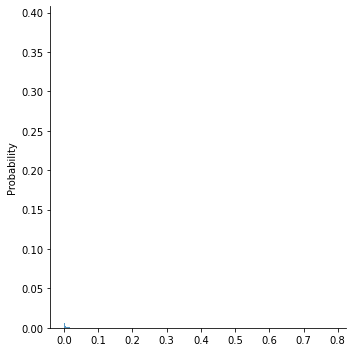

In [157]:
import seaborn as sns

# x = np.array(stat[1110]['h/w'])
x = np.array(stat[1110]['area/imgSize'])
sns.displot(x, stat='probability')
plt.show(True)

In [71]:
img = coco.loadImgs(1)
img

[{'id': 1,
  'width': 640,
  'height': 360,
  'file_name': '/SORDI/SORDI_2022_h4022_industrial rooms 360p/images/7548.jpg'}]